#CS6170 Computational Topology Final Project

Analysis of neuron images using Lucid and Dionysus

##Setup

In [3]:
#Installs
!pip install --quiet lucid==0.2.3
!pip -q install --verbose dionysus>=2.0.6
!pip -q install ripser
!pip -q install kmapper

    100% |████████████████████████████████| 102kB 20.2MB/s 


In [0]:
# General support
import math
import tensorflow as tf
import numpy as np

%matplotlib inline

# For plots
import matplotlib.pyplot as plt
from sklearn import manifold

# For saving
import pickle

# Lucid
from lucid.misc.io import save, show, load
import lucid.modelzoo.vision_models as models
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

# imports for homology computations
from ripser import Rips

# Mapper imports
import kmapper as km
from kmapper import cluster, Cover

In [0]:
### Model ###

#GoogLeNet
model = models.InceptionV1()
model.load_graphdef()

In [0]:
###Plotting routines
def plot_mds(distance_matrix, description):
  embedding = manifold.MDS(n_components=2, dissimilarity='precomputed')
  transformed = embedding.fit_transform(distance_matrix)
  plt.scatter(transformed[:, 0], transformed[:, 1])
  plt.title(description)
    
def plot_tsne(distance_matrix, description):
  embedding = manifold.TSNE(n_components=2, metric='precomputed')
  transformed = embedding.fit_transform(distance_matrix)
  plt.scatter(transformed[:, 0], transformed[:, 1])
  plt.title(description)

def plot_histogram(data, description):
  plt.hist(data[np.nonzero(data)] , bins=35)
  plt.title(description)

In [0]:
### General functions ###

"""
Generates a list of images
"""
def img_generator(n_nodes, node_generator, param_f):
  global model
  imgs = []
  for i in range(n_nodes):
    print(i)
    img = render.render_vis(model, node_generator(i), param_f)[0][0]
    imgs.append(img.reshape(img.shape[0] * img.shape[1], 3))
  return imgs

"""
Image normalizer
imgs is an np array size (n x (64*64) x 3)
Returns a copy of the array
"""
def normalize(imgs):
  ret = np.copy(imgs)
  ret[:, :, 2] = ret[:, :, 0] + ret[:, :, 1] + ret[:, :, 2]
  for i in range(64):
    for j in range(64):
      ret[:, i+j, 0] = i
      ret[:, i+j, 1] = j
  return ret

"""
Runs a rips complex on a set of imgs
"""
def rips_on_imgs(imgs):
  dgms = []
  for i in range(imgs.shape[0]):
    print("Image %d" %i)
    img = imgs[i]
    rips = Rips()
    dgms.append(rips.fit_transform(img))
  return dgms

"""
Runs a rips filtration on a single node
"""
def filtration(node, channel_f, opt_param, show_fig=False):
  global model
  print("Optimizing %d" % node)
  img = render.render_vis(model, channel_f(node), opt_param)
  img = img[0][0]
  img = img.reshape(img.shape[0]*img.shape[1], 3)
  rips = Rips()
  dgms = rips.fit_transform(img)
  if show_fig:
    rips.plot(dgms)
  return dgms
  
"""
Runs a rips filtration on a batch of n images. Returns an list of diagrams (np arrays)
"""
def n_nodes_filtration(n, channel_f, opt_param, show_fig=False):
  layer_dgms = []
  for i in range(n):
    layer_dgms.append(filtration(i, channel_f, opt_param, show_fig))
  return layer_dgms
  

In [0]:
### Mapper functions ###
"""
Runs a mapper projection 
"""
def run_mapper(dists, html_path, title):
  mapper = km.KeplerMapper(verbose=1)
  lens = mapper.fit_transform(dists)
  graph = mapper.map(
    lens,
    X=dists,
    cover=Cover(n_cubes=10, perc_overlap=0.4),
    clusterer=cluster.DBSCAN(metric="precomputed", min_samples=3, n_jobs=2),
    precomputed=True,
  )
  html = mapper.visualize(graph, path_html=html_path, title=title)

An example filtration
Optimizing 507
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


512 1618.8065



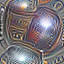

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


[array([[0.        , 0.00077204],
        [0.        , 0.00088026],
        [0.        , 0.00088026],
        ...,
        [0.        , 0.10348683],
        [0.        , 0.16126944],
        [0.        ,        inf]]), array([[0.11895037, 0.13564028],
        [0.11512312, 0.12884797],
        [0.10953075, 0.12487071],
        ...,
        [0.00861439, 0.0105716 ],
        [0.00827921, 0.0102248 ],
        [0.00664583, 0.00687506]])]

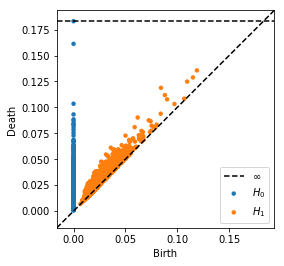

In [10]:
### Example Neuron visualization and filtration ###
print("An example filtration")
node = 507
filtration(node, lambda n: objectives.channel("mixed4a_pre_relu", n), lambda: param.image(64), show_fig=True)

##Computing the Homology of one neuron

###Naive with no regularizations

``

####Mixed4a layer

In [0]:
###Layer for experiments
layer = "mixed4a_pre_relu"

###Number of nodes in the layer
n_nodes = 508

###Helper lambda
channel = lambda l, n: objectives.channel(l, n)

###Optimization parameters
param_f = lambda: param.image(64)

###Setting the random seed for consistency
tf.random.set_random_seed(1723609)

In [0]:
### Filtration Generation ###
node_generator = lambda n: channel(layer, n)
dgms = n_nodes_filtration(n_nodes, node_generator, param_f)

with open("dgms.pkl", "wb") as dump_file: 
  pickle.dump(dgms, dump_file)
#Offline analysis of distance matrix

In [11]:
### Import distances and plot MDS and t-SNE projections ###
wasserstein_dim0 = np.load("wasserstein-0-mixed4a.npy")
wasserstein_dim1 = np.load("wasserstein-1-mixed4a.npy")
print("Max of dim0:")
print(np.amax(wasserstein_dim0.flatten()))
print("Max of dim1:")
print(np.amax(wasserstein_dim1.flatten()))

Max of dim0:
11.98443504981697
Max of dim1:
4.55412711575627


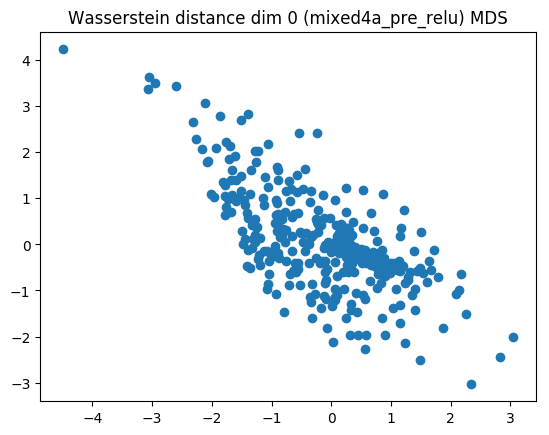

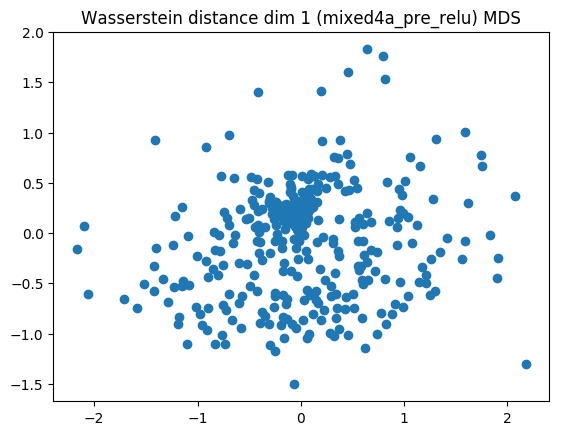

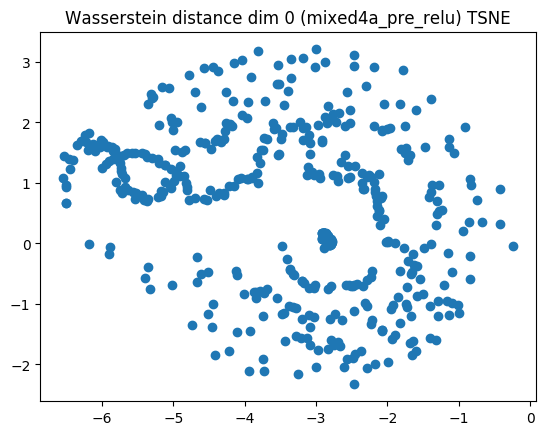

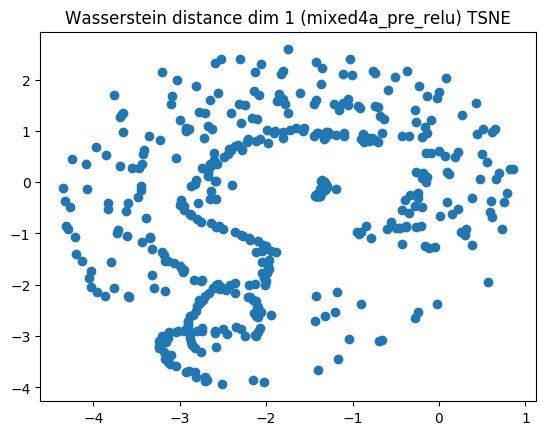

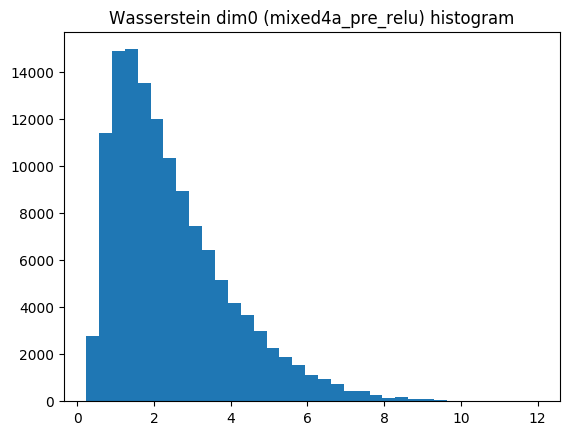

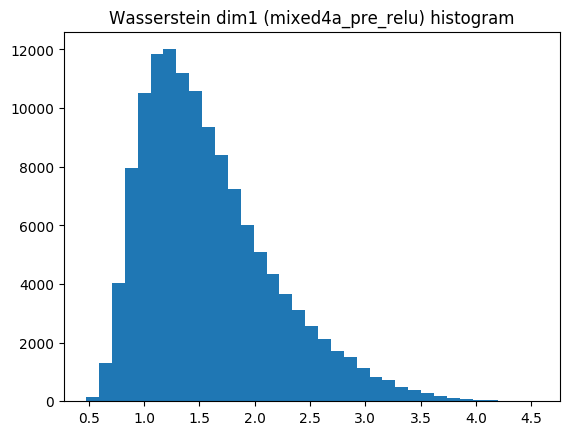

In [12]:
plot_mds(wasserstein_dim0, "Wasserstein distance dim 0 (mixed4a_pre_relu) MDS")
plt.show()
plot_mds(wasserstein_dim1, "Wasserstein distance dim 1 (mixed4a_pre_relu) MDS")
plt.show()
plot_tsne(wasserstein_dim0, "Wasserstein distance dim 0 (mixed4a_pre_relu) TSNE")
plt.show()
plot_tsne(wasserstein_dim1, "Wasserstein distance dim 1 (mixed4a_pre_relu) TSNE")
plt.show()
plot_histogram(wasserstein_dim0.flatten(), "Wasserstein dim0 (mixed4a_pre_relu) histogram")
plt.show()
plot_histogram(wasserstein_dim1.flatten(), "Wasserstein dim1 (mixed4a_pre_relu) histogram")
plt.show()

In [0]:
### Running a mapper projection ###
run_mapper(wasserstein_dim0, "mixed4a_color_dim0_mapper.html", "Wasserstein distance in dim0 for mixed4a")
run_mapper(wasserstein_dim1, "mixed4a_color_dim1_mapper.html", "Wasserstein distance in dim1 for mixed4a")

In [0]:
###Trying a greyscale filtration
node_generator = lambda n: objectives.channel(layer, n)
imgs = img_generator(n_nodes, node_generator, param_f)
imgs_norm = normalize(np.asarray(imgs))
dgms_grey = rips_on_imgs(imgs_norm)
with open("imgs_mixed4a.pkl", "wb") as p:
  pickle.dump(p, imgs)

np.save("mixed4a_imgs_grey.npy", imgs_norm)

####Conv2d1 layer 

A second lower level layer

Optimizing 0
512 106.95775



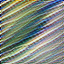

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 1
512 65.45712



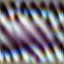

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 2
512 88.13659



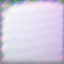

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 3
512 155.00334



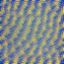

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 4
512 69.169136



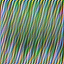

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 5
512 97.684494



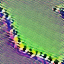

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 6
512 90.27031



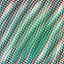

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 7
512 97.78798



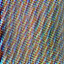

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 8
512 73.07701



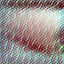

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 9
512 104.08612



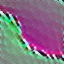

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 10
512 113.33163



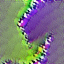

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 11
512 115.790375



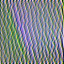

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 12
512 97.91257



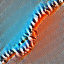

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 13
512 85.2283



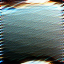

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 14
512 64.57998



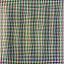

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 15
512 91.893265



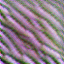

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 16
512 173.30449



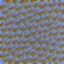

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 17
512 130.48946



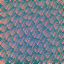

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 18
512 98.35461



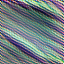

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 19
512 78.647644



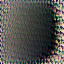

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 20
512 76.363304



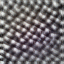

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 21
512 71.63089



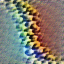

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 22
512 112.26239



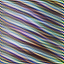

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 23
512 98.26138



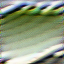

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 24
512 96.23565



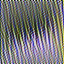

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 25
512 90.32101



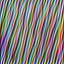

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 26
512 94.07364



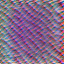

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 27
512 73.13111



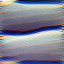

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 28
512 135.34747



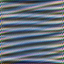

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 29
512 113.86284



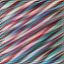

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 30
512 250.0711



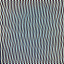

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 31
512 108.4489



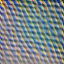

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 32
512 104.158966



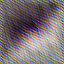

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 33
512 85.696304



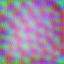

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 34
512 72.596306



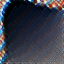

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 35
512 67.61772



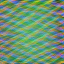

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 36
512 93.64287



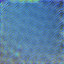

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 37
512 94.80092



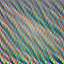

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 38
512 79.858315



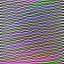

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 39
512 94.429634



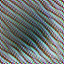

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 40
512 197.85155



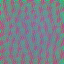

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 41
512 166.0627



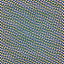

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 42
512 90.278496



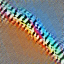

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 43
512 75.50918



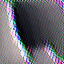

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 44
512 95.24823



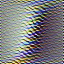

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 45
512 100.91822



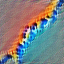

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 46
512 80.27304



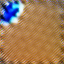

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 47
512 145.86478



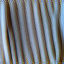

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 48
512 74.504395



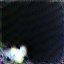

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 49
512 148.61876



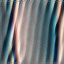

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 50
512 78.85912



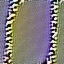

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 51
512 208.55978



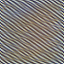

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 52
512 188.42244



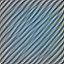

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 53
512 108.69637



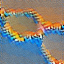

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 54
512 82.09762



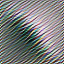

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 55
512 248.49863



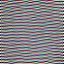

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 56
512 93.995



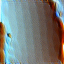

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 57
512 93.43823



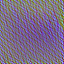

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 58
512 137.2394



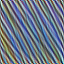

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 59
512 116.33496



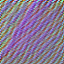

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 60
512 60.743336



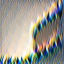

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 61
512 122.82192



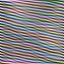

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 62
512 78.25816



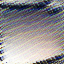

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Optimizing 63
512 128.337



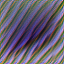

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [9]:
### A purely convolutional layer (one of the beginning layers of the network) ###
### Colored images 

layer = "conv2d1_pre_relu"
n_nodes = 64
node_generator = lambda n: objectives.channel(layer, n)

dgms = n_nodes_filtration(n_nodes, node_generator, param_f)

with open("dgms_conv2d1.pkl", "wb") as dump_file: 
  pickle.dump(dgms, dump_file)
# Offline analysis to compute distance matrix

In [0]:
wasserstein_dim0_conv2d = np.load("wasserstein-0-conv2d1.npy")
wasserstein_dim1_conv2d = np.load("wasserstein-1-conv2d1.npy")
print("Max of dim0:")
print(np.amax(wasserstein_dim0_conv2d.flatten()))
print("Max of dim1:")
print(np.amax(wasserstein_dim1_conv2d.flatten()))

In [0]:
plot_mds(wasserstein_dim0_conv2d, "Wasserstein distance dim0 (conv2d) MDS")

In [0]:
plot_mds(wasserstein_dim1_conv2d, "Wasserstein distance dim1 (conv2d) MDS")

In [0]:
plot_tsne(wasserstein_dim0_conv2d, "Wasserstein distance dim0 (conv2d) t-SNE")

In [0]:
plot_tsne(wasserstein_dim1_conv2d, "Wasserstein distance dim1 (conv2d) t-SNE")

In [0]:
### Running mapper ###
run_mapper(wasserstein_dim0_conv2d, "conv2d1_color_dim0_mapper.html", "Wasserstein distance in dim0 for conv2d1")
run_mapper(wasserstein_dim1_conv2d, "conv2d1_color_dim1_mapper.html", "Wasserstein distance in dim1 for conv2d1")

0
512 92.06323



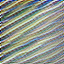

1
512 80.51132



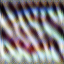

2
512 82.23978



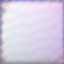

3
512 153.13612



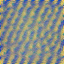

4
512 92.57788



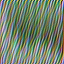

5
512 84.06128



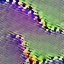

6
512 81.429695



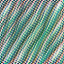

7
512 82.88282



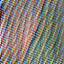

8
512 80.08694



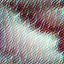

9
512 112.80788



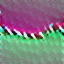

10
512 109.56952



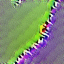

11
512 120.48375



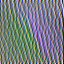

12
512 95.684006



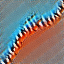

13
512 83.61069



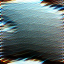

14
512 106.30309



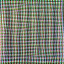

15
512 106.73416



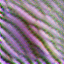

16
512 174.26746



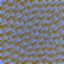

17
512 128.65869



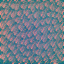

18
512 109.65635



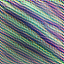

19
512 73.97946



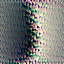

20
512 70.900154



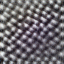

21
512 72.93808



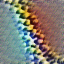

22
512 77.1289



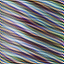

23
512 93.359726



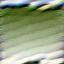

24
512 90.98236



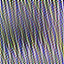

25
512 104.531746



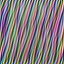

26
512 91.07194



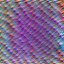

27
512 69.60541



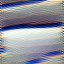

28
512 148.57915



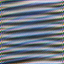

29
512 87.26585



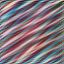

30
512 235.83963



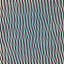

31
512 125.40671



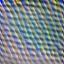

32
512 102.995094



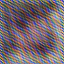

33
512 86.883316



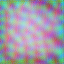

34
512 62.265606



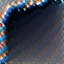

35
512 71.910645



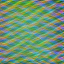

36
512 82.96158



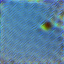

37
512 89.19149



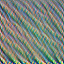

38
512 90.41166



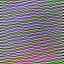

39
512 92.45787



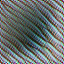

40
512 188.91553



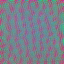

41
512 167.16795



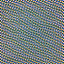

42
512 89.931366



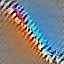

43
512 73.920204



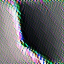

44
512 91.30704



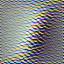

45
512 94.66725



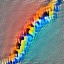

46
512 77.89463



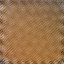

47
512 124.15247



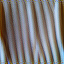

48
512 83.64908



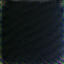

49
512 144.71071



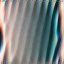

50
512 77.99235



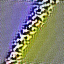

51
512 199.44254



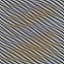

52
512 191.79868



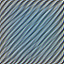

53
512 113.8653



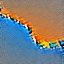

54
512 102.09095



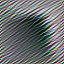

55
512 258.406



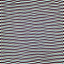

56
512 97.71157



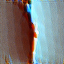

57
512 93.33305



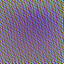

58
512 136.77364



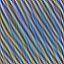

59
512 103.382996



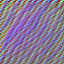

60
512 66.48658



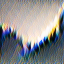

61
512 84.061195



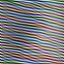

62
512 68.162834



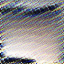

63
512 125.26681



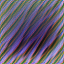

Image 0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 1
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 2
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 3
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 4
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 5
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 6
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 7
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 8
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 9
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Image 10
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, v

FileNotFoundError: ignored

In [39]:
### Greyscale filtration ###
layer = "conv2d1_pre_relu"
n_nodes = 64
node_generator = lambda n: objectives.channel(layer, n)

imgs_conv2d = img_generator(n_nodes, node_generator, param_f)
dgms_grey_conv = rips_on_imgs(normalize(np.asarray(imgs_conv2d)))

with open("conv2d_grey_dgms.pkl", 'wb') as p:
  pickle.dump(dgms_grey_conv, p)

np.save("conv2d1_imgs.npy", np.asarray(imgs_conv2d))